# **Latent Semantic Analysis (LSA)**

Latent Semantic Analysis (LSA) involves creating structured data from a collection of unstructured texts. Before getting into the concept of LSA, let us have a quick intuitive understanding of the concept. When we write anything like text, the words are not chosen randomly from a vocabulary.

Rather, we think about a theme (or topic) and then chose words such that we can express our thoughts to others in a more meaningful way. This theme or topic is usually considered as a latent dimension.



It is latent because we can’t see the dimension explicitly. Rather, we understand it only after going through the text. This means that most of the words are semantically linked to other words to express a theme. So, if words are occurring in a collection of documents with varying frequencies, it should indicate how different people try to express themselves using different words and different topics or themes.

In other words, word frequencies in different documents play a key role in extracting the latent topics. LSA tries to extract the dimensions using a machine learning algorithm called Singular Value Decomposition or SVD.

**Install Datasets**

In [1]:
!wget http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip
!unzip bbc-fulltext.zip

--2024-08-20 07:58:18--  http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip
Resolving mlg.ucd.ie (mlg.ucd.ie)... 137.43.93.132
Connecting to mlg.ucd.ie (mlg.ucd.ie)|137.43.93.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874079 (2.7M) [application/zip]
Saving to: ‘bbc-fulltext.zip’

bbc-fulltext.zip    100%[===================>]   2.74M  2.15MB/s    in 1.3s    

2024-08-20 07:58:21 (2.15 MB/s) - ‘bbc-fulltext.zip’ saved [2874079/2874079]

Archive:  bbc-fulltext.zip
   creating: bbc/
   creating: bbc/entertainment/
  inflating: bbc/entertainment/289.txt  
  inflating: bbc/entertainment/262.txt  
  inflating: bbc/entertainment/276.txt  
  inflating: bbc/entertainment/060.txt  
  inflating: bbc/entertainment/074.txt  
  inflating: bbc/entertainment/048.txt  
  inflating: bbc/entertainment/114.txt  
  inflating: bbc/entertainment/100.txt  
  inflating: bbc/entertainment/128.txt  
  inflating: bbc/entertainment/316.txt  
  inflating: bbc/entertainment/302.txt 

**Import Libraries**

In [8]:
import pandas as pd
import os, re
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import pairwise_distances
import numpy as np
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Read Data**

In [3]:
# Read each file as text files and put in a data frame
folders = os.listdir('/content/bbc/')
folders

['entertainment', 'politics', 'sport', 'tech', 'README.TXT', 'business']

**Create Dataframe**

In [4]:
folders.remove('README.TXT')

In [5]:
df_dict = {'topic':[], 'news':[]}

for folder in folders:

    files = os.listdir('/content/bbc/'+folder)

    for file in files:

        path = '/content/bbc/'+folder+'/'+file

        f = open(path, 'r', errors='ignore').read()

        df_dict['topic'].append(folder)

        df_dict['news'].append(str(f))




df = pd.DataFrame(df_dict)

df.head()

,topic,news
0,entertainment,Scissor Sisters triumph at Brits\n\nUS band Sc...
1,entertainment,Pupils to get anti-piracy lessons\n\nLessons o...
2,entertainment,Actor Scott is new Bond favourite\n\nBookmaker...
3,entertainment,"Beatles suits sell for $110,000\n\nFour suits ..."
4,entertainment,Franz man seeks government help\n\nFranz Ferdi...


**Preprocess Data**

In [6]:
def simple_preprocessing(text):
    heading = re.findall("^.+(?=\n)", text) # Extract the first line as heading
    text = re.sub(heading[0], '', text) # Remove the heading
    text = re.sub('\n', ' ', text) # Replace newline character with whitespace
    text = re.sub('[$(.%),;!?]+','', text) # Remove common punctuations
    text = text.strip() # Remove leading and training whitespaces
    return (heading[0], text)

news_and_heading = [simple_preprocessing(txt.lower()) for txt in df['news']]
df_final = pd.concat([df, pd.DataFrame.from_records(news_and_heading, columns=['Heading','News'])], axis=1)

# Document Clustering for Latent Semantic Analysis

Document clustering is helpful in many ways to cluster documents based on their similarities with each other. They are useful in law firms, medical record segregation, segregation of books, and in many different scenarios.  Clustering algorithms are usually meant to deal with dense matrix and not sparse matrix which is created during the creation of document term matrix. Using LSA, a low-rank approximation of the original matrix can be created (with some loss of information although!) that can be used for our clustering purpose. The following codes show how to create the document-term matrix and how LSA can be used for document clustering.

In [9]:
stopword_list = stopwords.words('english')
dtm = CountVectorizer(max_df=0.7, min_df=5, token_pattern="[a-z']+",
                      stop_words=stopword_list, max_features=2000) # Only top 2000 most frequently ocurring words are considered
dtm.fit(df_final['News'])
dtm_mat = dtm.transform(df_final['News'])

In [10]:
tsvd = TruncatedSVD(n_components=200)
tsvd.fit(dtm_mat)
tsvd_mat = tsvd.transform(dtm_mat)
s_list = []

100%|██████████| 19/19 [02:12<00:00,  6.96s/it]


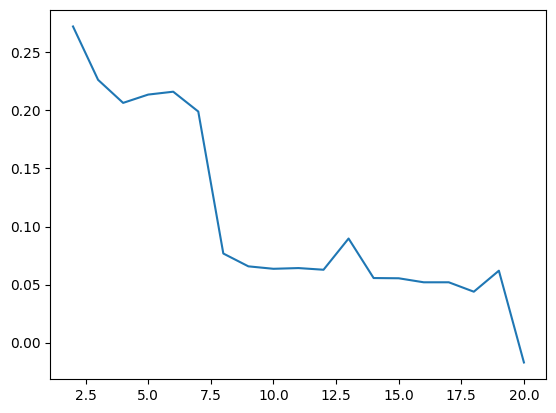

In [11]:
for clus in tqdm(range(2,21)):
    km = KMeans(n_clusters=clus, n_init=50, max_iter=1000) # Instantiate KMeans clustering
    km.fit(tsvd_mat) # Run KMeans clustering
    s = silhouette_score(tsvd_mat, km.labels_)
    s_list.append(s)

plt.plot(range(2,21), s_list)

plt.show()

The plot shows clearly that the silhouette scores are quite low. Thus, either the clusters are not linearly separable or there is a considerable amount of overlaps among them. A TSNE plot is better suited in such a case. The TSNE plot extracts a low dimensional representation of high dimensional data through a non-linear embedding method which tries to retain the local structure of the data. The code as well as the TSNE plot is shown below.

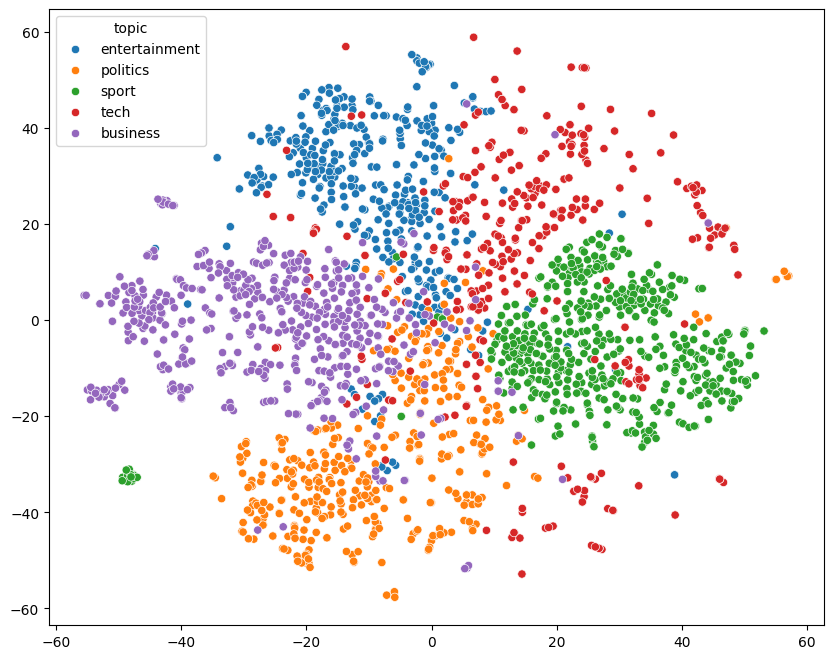

In [13]:
tsne = TSNE(n_components=2)
tsne_mat = tsne.fit_transform(tsvd_mat)
plt.figure(figsize=(10,8))
sns.scatterplot(x=tsne_mat[:,0], y=tsne_mat[:,1], hue=df_final['topic'])

plt.show()

In this plot, only the tech-related news article looks like having a much wider spread whereas other news articles look quite nicely clustered. It also suggests that LSA (or Truncated SVD) has done a good job on the textual data to extract 200 important dimensions to segregate news articles on different topics. It is to be understood that TSNE is non-deterministic in nature and multiple runs will produce multiple representations, even though, the structure will be more likely to remain similar if not the same. This LSA can be also used for text queries, for example,

Query: “How is Microsoft performing in computer game?”

This query can be sent through the pipeline of document-term matrix creation which would be followed by LSA operation to create the necessary document vector and that can be compared with the vectors of news articles. The following codes show that result:

In [14]:
query = "How is Microsoft performing in computer game?"
query_mat = tsvd.transform(dtm.transform([query]))
dist = pairwise_distances(X=tsvd_mat, Y=query_mat, metric='cosine')
df_final['News'][np.argmin(dist.flatten())]

'xbox video game halo 2 has been released in the us on 9 november with a uk release two days later why is the game among the most anticipated of all time  halo is considered by many video game pundits to be one of the finest examples of interactive entertainment ever produced and more than 15 million people worldwide have pre-ordered the sequel a science fiction epic halo centred the action on a human cyborg controlled by the player who had to save his crew from an alien horde after a crash landing on a strange and exotic world contained on the interior surface of a giant ring in space remembrance of things past it was not - but as a slice of schlock science fiction inspired by works such as larry niven\'s ringworld and the film starship troopers it fit the bill perfectly halo stood out from a crowd of similar titles - it was graphically impressive had tremendous audio using dolby digital a decent storyline instant playability and impressive physics  but what marked halo as a classic w